# **Block 5: Other pysteps functionalities**

# Blending with NWP
Install pysteps and configure it. 

In [ ]:
from google.colab import drive
import os
# mount the Google Drive folder
# don't attempt to remount if the drive is already mounted
if not os.path.exists("/content/mnt/MyDrive"):
  drive.mount("mnt")
%cd '/content/mnt/MyDrive/Colab Notebooks'
# run the previous notebook to configure the environment
%run block_01_setup.ipynb

Mounted at mnt
/content/mnt/MyDrive/Colab Notebooks
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 6.3 MB 5.4 MB/s 
Found existing installation: Shapely 1.8.2
Uninstalling Shapely-1.8.2:
  Successfully uninstalled Shapely-1.8.2
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 198 kB 5.2 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for shapely: filename=Shapely-1.8.2-cp37-cp37m-linux_x86_64.whl size=668922 sha256=c9d512c0f9b9b23a62fd77b7fce7f34953651bf60b54aae10b265ac2ba7aecd4
  Stored in directory: /root/.cache/pip/wheels/2f/9e/07/e9e90942b4e31275785d2f7e455607bfe876e53906307f80cd
Successfully built shapely
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
 

## Load the example dataset

Now that we have initialized the notebook, let's import the example RMI radar and NWP dataset. To run this, the [pysteps-nwp-importers](https://github.com/pySTEPS/pysteps-nwp-importers) plugin needs to be installed in addition to the pysteps installation. The example RMI and NWP data is from a case on 4 July 2021 from 16:05 until 18:00 UTC.

In [ ]:
# Install the nwp importers plugin
!pip install git+https://github.com/pySTEPS/pysteps-nwp-importers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/pySTEPS/pysteps-nwp-importers to /tmp/pip-req-build-_mgx8jib
  Running command git clone -q https://github.com/pySTEPS/pysteps-nwp-importers /tmp/pip-req-build-_mgx8jib
  Created wheel for pysteps-nwp-importers: filename=pysteps_nwp_importers-0.1-py2.py3-none-any.whl size=15551 sha256=9e978f5a150b951f529230964edabea2a171cbf5d300d188a205cfa4878cb3ed
  Stored in directory: /tmp/pip-ephem-wheel-cache-ke_glfyk/wheels/fd/7a/bd/66e4b147bcf7f958c4d9f3f1a499b71504cc62304a515661e8
Successfully built pysteps-nwp-importers


In [ ]:
# Reconfigure and reload the pystepsrc file
from pysteps.datasets import create_default_pystepsrc
config_file_path = create_default_pystepsrc("pysteps_data")
import pysteps
_ = pysteps.load_config_file(config_file_path, verbose=True)

Pysteps configuration file found at: /root/.pysteps/pystepsrc



In [ ]:
import datetime
import numpy as np
import pysteps_nwp_importers

In [ ]:
# Selected case
date_radar = datetime.datetime.strptime("202107041605", "%Y%m%d%H%M")
# The last NWP forecast was issued at 12:00 UTC
date_nwp = datetime.datetime.strptime("202107041200", "%Y%m%d%H%M")
radar_data_source = pysteps.rcparams.data_sources["rmi"]
nwp_data_source = pysteps.rcparams.data_sources["rmi_nwp"]

# Get the paths from the pystepsrc file
root_path = radar_data_source["root_path"]
path_fmt = radar_data_source["path_fmt"]
#fn_pattern = radar_data_source["fn_pattern"]
fn_pattern = "%Y%m%d%H%M00.rad.best.comp.rate.qpe"
fn_ext = radar_data_source["fn_ext"]
importer_name = radar_data_source["importer"]
importer_kwargs = radar_data_source["importer_kwargs"]
timestep = radar_data_source["timestep"]

# Find the radar files in the archive
fns = pysteps.io.find_by_date(
    date_radar, root_path, path_fmt, fn_pattern, fn_ext, timestep, num_prev_files=2, num_next_files=23,
)

# Read the radar composites
importer = pysteps.io.get_method(importer_name, "importer")
radar_precip_full, _, radar_metadata = pysteps.io.read_timeseries(fns, importer, **importer_kwargs)
print(radar_metadata)
# Keep the first three time steps as the input data for the nowcasts and the 
# remaining time steps as observations for comparison with the forecast
radar_precip = radar_precip_full[0:3]
precip_obs = radar_precip_full[3:]
precip_obs_metadata = radar_metadata.copy()


# Import the NWP data
filename = os.path.join(
    nwp_data_source["root_path"],
    datetime.datetime.strftime(date_nwp, nwp_data_source["path_fmt"]),
    datetime.datetime.strftime(date_nwp, nwp_data_source["fn_pattern"])
    + "."
    + nwp_data_source["fn_ext"],
)

nwp_precip, _, nwp_metadata = pysteps_nwp_importers.importer_rmi_nwp.import_rmi_nwp(filename)
print(nwp_metadata)

# Make sure the units are in mm/h (note that the linear blending code also does 
# this automatically for you)
converter = pysteps.utils.get_method("mm/h")
radar_precip, radar_metadata = converter(radar_precip, radar_metadata)
precip_obs, precip_obs_metadata = converter(precip_obs, precip_obs_metadata)
nwp_precip, nwp_metadata = converter(nwp_precip, nwp_metadata)

{'projection': '+proj=lcc +lat_1=49.83333333333334 +lat_2=51.16666666666666 +lat_0=50.797815 +lon_0=4.359215833333333 +x_0=649328 +y_0=665262 +ellps=GRS80 +towgs84=0,0,0,0,0,0,0 +units=m +no_defs ', 'll_lon': -0.2666973996088157, 'll_lat': 47.41679117656605, 'ur_lon': 9.664159875778674, 'ur_lat': 53.69199685747096, 'x1': 300000.00000639487, 'y1': 300000.00010250637, 'x2': 999999.9999935811, 'y2': 1000000.0000994017, 'xpixelsize': 1000.0, 'ypixelsize': 1000.0, 'cartesian_unit': 'm', 'yorigin': 'upper', 'institution': 'Odyssey datacentre', 'accutime': 5.0, 'unit': 'mm/h', 'transform': None, 'zerovalue': 0.0, 'threshold': 0.04034535586833954, 'timestamps': array([datetime.datetime(2021, 7, 4, 15, 55),
       datetime.datetime(2021, 7, 4, 16, 0),
       datetime.datetime(2021, 7, 4, 16, 5),
       datetime.datetime(2021, 7, 4, 16, 10),
       datetime.datetime(2021, 7, 4, 16, 15),
       datetime.datetime(2021, 7, 4, 16, 20),
       datetime.datetime(2021, 7, 4, 16, 25),
       datetime.da

## Visualize the data
Plot the radar rainfall field and the first time step of the NWP forecast.

/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:
/usr/local/lib/python3.7/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naci

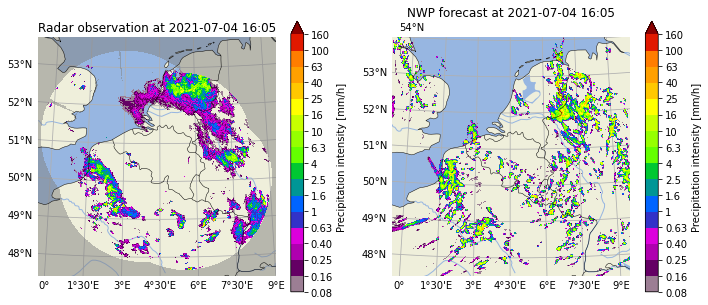

In [ ]:
from matplotlib import pyplot as plt
from pysteps.visualization import plot_precip_field

date_str = datetime.datetime.strftime(date_radar, "%Y-%m-%d %H:%M")

map_kwargs = {"drawlonlatlines": True}
plt.figure(figsize=(10, 5))
plt.subplot(121)

# First plot the radar data
plot_precip_field(
    radar_precip[-1, :, :],
    geodata=radar_metadata,
    title=f"Radar observation at {date_str}",
    colorscale="...", # You can choose the colorscale! 
    map_kwargs=map_kwargs,
)

# Then plot the NWP data
plt.subplot(122)
plot_precip_field(
    nwp_precip[0, :, :], 
    geodata=nwp_metadata, 
    title=f"NWP forecast at {date_str}", 
    colorscale="...", # You can choose the colorscale! 
    map_kwargs=map_kwargs
)
plt.tight_layout()
plt.show()

## Reproject NWP data on radar grid
Reproject the NWP data using the [reprojection module](https://pysteps.readthedocs.io/en/latest/pysteps_reference/utils.html?highlight=reprojection#pysteps-utils-reprojection) and visualize the data again.

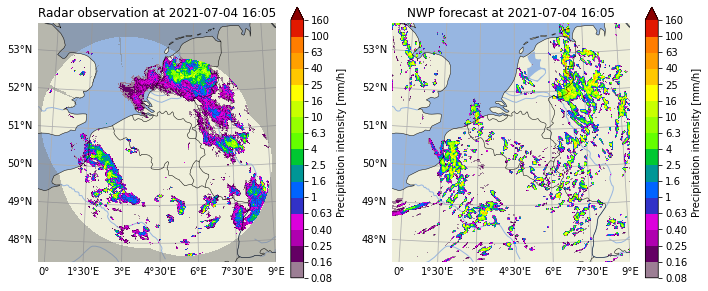

In [ ]:
# Reproject the projection of the nwp data to the projection of the radar data
nwp_precip, nwp_metadata = ...

# Let's plot it again to see the difference (plot it yourself or use the previous
# code to make a plot)
...

## Linear blending
### Pre-processing steps
The pre-processing steps prior to the linear blending consist of thresholding the data, optional data transformations and the estimation of the velocity field for the radar rainfall nowcast (see also block 2 and 3).

In [ ]:
# Threshold the data (here: simple threshold of 0.1 mm/h used)
radar_precip[radar_precip < 0.1] = 0.0
nwp_precip[nwp_precip < 0.1] = 0.0

# Only keep the NWP forecasts from 2021-07-04 16:10 onwards, because the first
# forecast lead time starts at 16:10 if the issue time is 16:05.
nwp_precip_slice = nwp_precip[1:].copy()

# Transform the radar data to dB - this transformation is useful for the motion
# field estimation and the subsequent nowcasts. The NWP forecast is not
# transformed, because the linear blending code sets everything back in mm/h
# after the nowcast.
transformer = pysteps.utils.get_method("dB")
radar_precip, radar_metadata = transformer(radar_precip, 
                                           radar_metadata, 
                                           threshold=0.1,
                                           )

# Determine the velocity field
oflow_method = pysteps.motion.get_method("lucaskanade")
velocity_radar = oflow_method(radar_precip)

### The linear blending forecast


In [ ]:
precip_blended_linear = pysteps.blending.linear_blending.forecast(
    precip=radar_precip[-1, :, :],
    precip_metadata=radar_metadata,
    velocity=velocity_radar,
    timesteps=23,
    timestep=5,
    nowcast_method="extrapolation",  # simple advection nowcast
    precip_nwp=nwp_precip_slice,
    precip_nwp_metadata=nwp_metadata,
    start_blending=30,  # in minutes (this is an arbritrary choice)
    end_blending=90,  # in minutes (this is an arbritrary choice)
)

### Visualize the output and give an indication of the skill

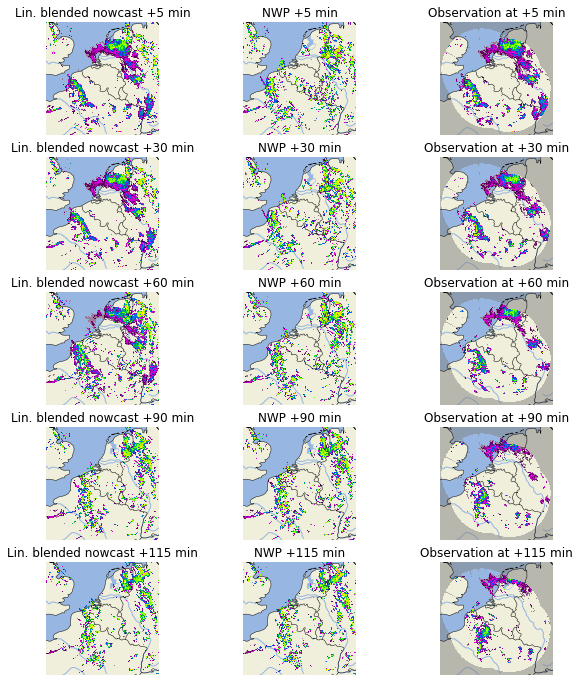

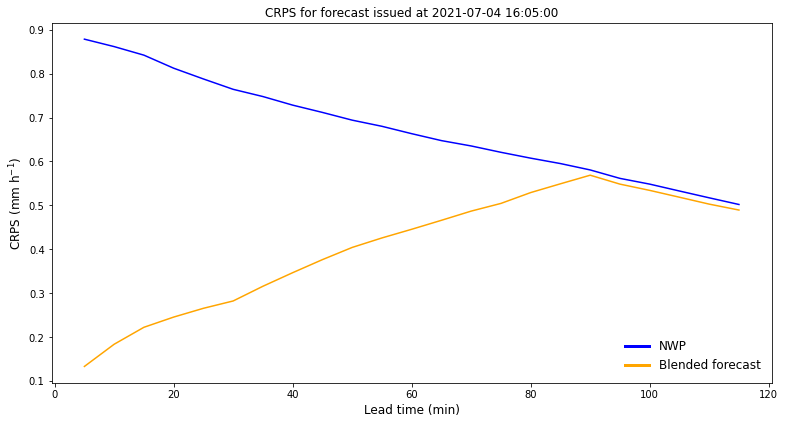

In [ ]:
from matplotlib.lines import Line2D

fig = plt.figure(figsize=(10, 12))

leadtimes_min = [5, 30, 60, 90, 115]
n_leadtimes = len(leadtimes_min)
for n, leadtime in enumerate(leadtimes_min):

    # Nowcast with blending into NWP
    plt.subplot(n_leadtimes, 3, n * 3 + 1)
    plot_precip_field(
        precip_blended_linear[int(leadtime / timestep) - 1, :, :],
        geodata=radar_metadata,
        title=f"Lin. blended nowcast +{leadtime} min",
        axis="off",
        colorbar=False,
    )

    # Raw NWP forecast
    plt.subplot(n_leadtimes, 3, n * 3 + 2)
    plot_precip_field(
        nwp_precip[int(leadtime / timestep) - 1, :, :],
        geodata=nwp_metadata,
        title=f"NWP +{leadtime} min",
        axis="off",
        colorbar=False,
    )

    # The observed rainfall
    plt.subplot(n_leadtimes, 3, n * 3 + 3)
    plot_precip_field(
        precip_obs[int(leadtime / timestep) - 1, :, :],
        geodata=radar_metadata,
        title=f"Observation at +{leadtime} min",
        axis="off",
        colorbar=False,
    )
    
# Determine the skill of both forecasts
# We will use the CRPS (but feel free to use any other skill score), as it allows
# us to do tests with ensemble forecasts later on.
# Make an empty list of the CRPS per lead time
CRPS_lt = dict({'blended': [], 'NWP': []})
n_timesteps = 23
for lt in range(n_timesteps):
    CRPS_lt['blended'].append(pysteps.verification.probscores.CRPS(np.stack([precip_blended_linear[lt,:,:]]),precip_obs[lt,:,:]))
    CRPS_lt['NWP'].append(pysteps.verification.probscores.CRPS(np.stack([nwp_precip[lt,:,:]]),precip_obs[lt,:,:]))

# Plot it
fig = plt.figure(figsize = (10,5))
fig1 = fig.add_gridspec(1, 1, bottom = 0.0, top = 1.00, left = 0.0, right = 1.0) 
ax1 = fig.add_subplot(fig1[0,0])

# Plot the CRPS for both lead times
ax1.plot(
    (np.arange(n_timesteps)+1)*5,
    CRPS_lt['NWP'],
    color="blue",
)
ax1.plot(
    (np.arange(n_timesteps)+1)*5,
    CRPS_lt['blended'],
    color="orange",
)

ax1.set_xlabel("Lead time (min)", fontsize=12)
ax1.set_ylabel(r"CRPS (mm h$^{-1}$)", fontsize=12)

ax1.set_title(f"CRPS for forecast issued at {date_radar}")

# Set the legend
legend_elements_cmls = [Line2D([0], [0], color='blue', label="NWP", linewidth = 3),
                        Line2D([0], [0], color='orange', label="Blended forecast", linewidth = 3),]

ax1.legend(handles=legend_elements_cmls, loc='lower right', frameon = False, fontsize = 12, ncol = 1)

plt.tight_layout()
plt.show()


# Linear blending with different settings
Now, try out the linear blending with different settings. Can you manage to improve the forecast skill?

In [ ]:
precip_blended_linear = ...

In [ ]:
# Plot it
...

## Salient blending
Make a saliency-based blended forecast and visualize the output.

In [ ]:
precip_salient_blended = ...

In [ ]:
# Plot it


## STEPS blending

### Pre-processing steps
Add a few more pre-processing steps on top of the pre-processing steps that have already been done.

In [ ]:
# transform the data to dB
transformer = pysteps.utils.get_method("dB")
nwp_precip, nwp_metadata = transformer(nwp_precip, nwp_metadata, threshold=0.1)

# nwp_precip has to be four dimentional (n_models, time, y, x).
# If we only use one model (which is the case here):
if nwp_precip.ndim == 3:
    nwp_precip = nwp_precip[None, :]

### Determine the velocity field of the NWP forecast
We have already determined the velocity field of observed radar rainfall fields, but the STEPS blending procedure also requires the velocity field of the NWP forecast.

In [ ]:
# Then for the NWP forecast
velocity_nwp = []
# Loop through the models
for n_model in range(nwp_precip.shape[0]):
    # Loop through the timesteps. We need two images to construct a motion
    # field, so we can start from timestep 1. Timestep 0 will be the same
    # as timestep 1.
    _v_nwp_ = []
    for t in range(1, nwp_precip.shape[1]):
        v_nwp_ = oflow_method(nwp_precip[n_model, t - 1 : t + 1, :])
        _v_nwp_.append(v_nwp_)
        v_nwp_ = None
    # Add the velocity field at time step 1 to time step 0.
    _v_nwp_ = np.insert(_v_nwp_, 0, _v_nwp_[0], axis=0)
    velocity_nwp.append(_v_nwp_)
velocity_nwp = np.stack(velocity_nwp)

### The STEPS blended forecast
We only run it with 1 ensemble member to keep run times quick.

In [ ]:
precip_forecast_steps = pysteps.blending.steps.forecast(
    precip=radar_precip,
    precip_models=nwp_precip,
    velocity=velocity_radar,
    velocity_models=velocity_nwp,
    timesteps=23,
    timestep=timestep,
    issuetime=date_radar,
    n_ens_members=1,
    precip_thr=radar_metadata["threshold"],
    kmperpixel=radar_metadata["xpixelsize"] / 1000.0,
    noise_stddev_adj="auto",
    vel_pert_method=None,
)

STEPS blending

Inputs
------
forecast issue time:         2021-07-04T16:05:00
input dimensions:            700x700
km/pixel:                    1.0
time step:                   5 minutes

NWP and blending inputs
-----------------------
number of (NWP) models:      1
blend (NWP) model members:   False
decompose (NWP) models:      yes

Methods
-------
extrapolation:               semilagrangian
bandpass filter:             gaussian
decomposition:               fft
noise generator:             nonparametric
noise adjustment:            yes
velocity perturbator:        None
blending weights method:     bps
conditional statistics:      no
precip. mask method:         incremental
probability matching:        cdf
FFT method:                  numpy
domain:                      spatial

Parameters
----------
number of time steps:        23
ensemble size:               1
parallel threads:            1
number of cascade levels:    8
order of the AR(p) model:    2
precip. intensity threshold: -10

In [ ]:
# Transform the data back into mm/h
precip_forecast_steps, _ = converter(precip_forecast_steps, radar_metadata)
nwp_precip, _ = converter(nwp_precip, nwp_metadata)

### Visualize the output and give an indication of the skill

In [ ]:
# Plot it
...